In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

# Train Data

In [2]:
geographic_df = pd.read_csv('geographic_data.csv')
airport_df = pd.read_csv('training_set_airport_data.csv')
weather_df = pd.read_csv('Weather_data.csv')
# Converted the ACchar.xlsx to a csv file
AC_df = pd.read_csv('ACchar.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merging Datasets

### Airport Dataset

In [3]:
airport_df.head()

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway
0,1/1/2015 6:00,B737-800 WINGLETS,1/1/2015 5:56,1/1/2015 6:05,STAND_62,RUNWAY_4
1,1/1/2015 6:10,A320-100/200,1/1/2015 6:08,1/1/2015 6:18,STAND_153,RUNWAY_4
2,1/1/2015 6:15,A320-100/200,1/1/2015 6:08,1/1/2015 6:19,STAND_44,RUNWAY_2
3,1/1/2015 6:20,A320-100/200,1/1/2015 6:24,1/1/2015 6:36,STAND_7,RUNWAY_3
4,1/1/2015 6:20,A319,1/1/2015 6:14,1/1/2015 6:27,STAND_17,RUNWAY_2


In [4]:
airport_df.describe()

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway
count,543813,543813,543813,543813,543813,543813
unique,244764,143,461674,538720,166,4
top,5/2/2015 6:10,A319,5/12/2016 17:34,3/22/2016 8:48,STAND_61,RUNWAY_2
freq,9,178048,5,3,3453,136375


In [5]:
airport_df['Flight Datetime'] = pd.to_datetime(airport_df['Flight Datetime'], format = '%m/%d/%Y %H:%M')
airport_df['AOBT'] =  pd.to_datetime(airport_df['AOBT'], format='%m/%d/%Y %H:%M')
airport_df['ATOT'] =  pd.to_datetime(airport_df['ATOT'], format='%m/%d/%Y %H:%M')

### Geographic Dataset

In [6]:
geographic_df.describe()

,Lat_runway,Lng_runway,Lat_stand,Lng_stand
count,19545.000000,19545.000000,19545.000000,19545.000000
mean,54.757430,-0.007600,54.767112,0.015223
std,0.002815,0.020570,0.002567,0.006758
min,54.755307,-0.024107,54.761081,-0.009674
25%,54.755307,-0.023040,54.765141,0.010050
50%,54.755307,-0.023040,54.766471,0.016204
75%,54.761173,0.019840,54.769007,0.020901
max,54.761493,0.019840,54.773947,0.026379


In [7]:
# Merging airport_df with geographic_df on the runway and stand columns
runway_df = np.hsplit(geographic_df, 2)[0].drop_duplicates()
stand_df = np.hsplit(geographic_df, 2)[1].drop_duplicates()

In [8]:
runway_df.describe()

,runway,Lat_runway,Lng_runway
count,4,4.000000,4.000000
unique,4,4.000000,4.000000
top,Runway_1,54.761173,-0.024107
freq,1,1.000000,1.000000


In [9]:
stand_df.describe()

,stand,Lat_stand,Lng_stand
count,167,167.000000,167.000000
unique,167,159.000000,165.000000
top,stand_100,54.770717,-0.001061
freq,1,2.000000,2.000000


In [10]:
runway_df['runway'] = runway_df['runway'].str.upper()
stand_df['stand'] = stand_df['stand'].str.upper()
runway_df['runway'] = np.where(runway_df['runway'] == 'RUNWAY_3', 'RUNWAY_4', runway_df['runway'])
runway_df['runway'] = np.where(runway_df['runway'] == 'RUNWAY_2', 'RUNWAY_3', runway_df['runway'])
runway_df['runway'] = np.where(runway_df['runway'] == 'RUNWAY_1', 'RUNWAY_2', runway_df['runway'])
runway_df['runway'] = np.where(runway_df['runway'] == 'RUNWAY_0', 'RUNWAY_1', runway_df['runway'])

df = pd.merge(airport_df, stand_df, left_on='Stand', right_on='stand', how='left')
df = pd.merge(df, runway_df, left_on='Runway', right_on='runway', how='left')
df = df.drop(columns = ['runway','stand'])

In [11]:
df['Taxi_time'] = (df['ATOT'] - df['AOBT'])/(np.timedelta64(1,'m')) * 60

### ACchar Dataset

In [12]:
ac_df = AC_df[['A320-100', 'ICAO Code', 'Wake Category']]
ac_df = ac_df.drop_duplicates()

In [13]:
ac_df

,A320-100,ICAO Code,Wake Category
0,Acro Sport,ACRO,L
1,Acro Sport II,ACR2,L
2,Cougar,COUG,L
3,Junior Ace,JACE,L
4,Super Ace,SACE,L
...,...,...,...
2759,Zlin Z-50,BA11,M
2760,Zlin Z-526 Akrobat,tbd,tbd
2761,Zlin Z-526 Trener Master,tbd,tbd
2762,Zlin Z-626,tbd,tbd


In [14]:
#df = pd.merge(df, ac_df, left_on = 'Aircraft Model', right_on = 'A320-100', how = 'left')

In [15]:
df['Aircraft Model'].unique()

array(['B737-800 WINGLETS', 'A320-100/200', 'A319', 'A321-100/200',
       'B737-400', 'A330-300', 'B787-800 Dreamliner', 'B757-200 WINGLETS',
       'A330-200', 'B747-400 Passenger', 'B777-300ER', 'B777-200',
       'B737-900ER', 'ERJ-195', 'DASH 8-Q400', 'A380-800',
       'L-100 HERCULES(C130) Freighter', 'A318', 'ATR 72-500', 'EMB-135',
       'B777-200LR', 'B737-700 WINGLETS', 'EMBRAER E75', 'B737-300',
       '100', 'B737-300 Freighter', 'B 95 TRAVEL AIR',
       'BD700 1A11 GLOBAL EXPRESS', 'B777-200ER', 'LEARJET 60',
       'P.180 AVANTI', 'A340-200', 'RJ100/115', 'EMB-170', 'ERJ-190',
       'EMB-500 PHENOM 100', 'CITATION 1 (C500)', 'Jet', 'A310-300',
       'B757-200 Passenger', 'FALCON 7X', 'G V', 'B737-500',
       'SA 365 DAUPHIN 2', 'PREMIER 1', 'C 550 CITATION II / BRAVO',
       'A109', 'C 180 SKYWAGON', 'C 510 MUSTANG',
       'BD700 1A10 GLOBAL EXPRESS', 'LEARJET 45', 'G IV / IV-SP',
       'EMB-145', 'B737-700', 'CHALLENGER 300', ' ', 'A340-600', '340',
       'CITA

In [16]:
df.isnull().sum()

Flight Datetime    0
Aircraft Model     0
AOBT               0
ATOT               0
Stand              0
Runway             0
Lat_stand          0
Lng_stand          0
Lat_runway         0
Lng_runway         0
Taxi_time          0
dtype: int64

### Weather Dataset

In [17]:
weather_df.describe()

,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipAccumulation,ozone
count,587880.000000,587880.000000,678035.000000,678035.000000,678060.000000,678035.000000,586405.000000,677724.000000,602743.000000,659256.000000,659076.000000,665516.000000,677610.000000,678060.000000,678060.000000
mean,0.001371,0.036736,53.987421,52.801968,46.833012,0.787469,1015.613270,7.540695,10.944332,195.828070,0.518889,1.404581,6.089224,0.000004,314.096017
std,0.008209,0.143193,11.007120,12.481697,8.993392,0.158343,10.407546,4.620054,7.969487,94.979673,0.293749,1.894080,1.490707,0.000361,20.853763
min,0.000000,0.000000,17.670000,10.380000,12.190000,0.250000,971.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031000,0.000000,212.500000
25%,0.000000,0.000000,46.460000,42.960000,41.000000,0.680000,1009.800000,4.630000,5.650000,122.000000,0.190000,0.000000,6.216000,0.000000,310.400000
50%,0.000000,0.000000,53.650000,53.650000,48.200000,0.820000,1016.800000,6.930000,9.180000,221.000000,0.480000,0.000000,6.216000,0.000000,310.400000
75%,0.000000,0.000000,61.190000,61.350000,53.590000,0.930000,1022.500000,10.290000,13.960000,260.000000,0.750000,2.000000,6.216000,0.000000,310.400000
max,0.332800,1.000000,93.510000,96.700000,69.450000,1.000000,1045.700000,33.120000,51.310000,359.000000,1.000000,9.000000,10.000000,0.137400,480.000000


In [18]:
weather_df.duplicated().sum()

645036

In [19]:
weather_df = weather_df.drop_duplicates(keep = 'first')
weather_df = weather_df.drop(columns = ['summary', 'icon', 'precipIntensity', 'precipProbability', 'pressure'])

In [20]:
#Create new column rounding flight datetime to nearest hour for mapping
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

df["Flight_Datetime_map"] = df["Flight Datetime"].map(lambda d: hour_rounder(d))

weather_df['time_hourly'] = pd.to_datetime(weather_df['time_hourly'])
#Left join train data with weather data on "Flight_Datetime_map" & "time_hourly"
df= pd.merge(df, weather_df, left_on="Flight_Datetime_map", right_on= "time_hourly", how='left')
df = df.drop(columns = 'time_hourly')

## Preprocessing

In [21]:
df.isnull().sum()

Flight Datetime            0
Aircraft Model             0
AOBT                       0
ATOT                       0
Stand                      0
Runway                     0
Lat_stand                  0
Lng_stand                  0
Lat_runway                 0
Lng_runway                 0
Taxi_time                  0
Flight_Datetime_map        0
temperature              924
apparentTemperature      924
dewPoint                 898
humidity                 924
windSpeed               1235
windGust               73553
windBearing            19623
cloudCover             19756
uvIndex                13412
visibility              1347
precipType               898
precipAccumulation       898
ozone                    898
dtype: int64

In [22]:
# filled all NA values with previous known values
df = df.fillna(method = 'ffill')

In [23]:
# check that all NA values are filled
df.isnull().sum()

Flight Datetime        0
Aircraft Model         0
AOBT                   0
ATOT                   0
Stand                  0
Runway                 0
Lat_stand              0
Lng_stand              0
Lat_runway             0
Lng_runway             0
Taxi_time              0
Flight_Datetime_map    0
temperature            0
apparentTemperature    0
dewPoint               0
humidity               0
windSpeed              0
windGust               0
windBearing            0
cloudCover             0
uvIndex                0
visibility             0
precipType             0
precipAccumulation     0
ozone                  0
dtype: int64

In [24]:
df.duplicated().sum()

0

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


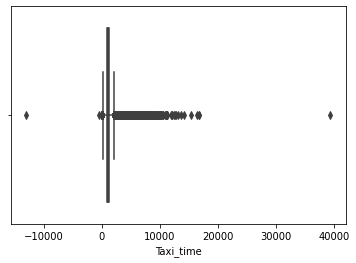

In [25]:
# Search for outliers
# remove the negative values and very large outliers
sns.boxplot(df['Taxi_time'])

In [26]:
# Remove 170 rows of taxi_time > 0
df = df[df['Taxi_time'] > 0]
# Remove 1 row (outlier) of taxi_time > 20000
df = df[df['Taxi_time'] < 20000]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


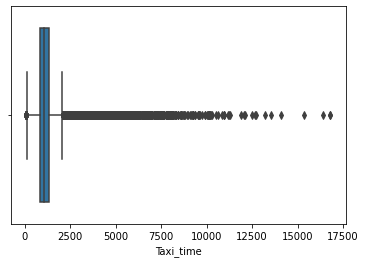

In [27]:
sns.boxplot(df['Taxi_time'])

## Feature Engineering

### Categorical Variables

In [30]:
df['precipType'].unique()

array(['None', 'rain', 'snow'], dtype=object)

In [31]:
df['icon'].unique()

array(['partly-cloudy-night', 'cloudy', 'partly-cloudy-day',
       'clear-night', 'clear-day', 'fog', 'rain', 'wind', 'snow'],
      dtype=object)

In [32]:
# the summary attribute is a combination of the precipType and icon attributes
df['summary'].unique()

array(['Mostly Cloudy', 'Overcast', 'Partly Cloudy', 'Clear', 'Foggy',
       'Rain', 'Light Rain', 'Drizzle', 'Possible Drizzle',
       'Windy and Partly Cloudy', 'Windy', 'Possible Light Rain',
       'Windy and Mostly Cloudy', 'Light Rain and Windy',
       'Dangerously Windy and Mostly Cloudy', 'Flurries'], dtype=object)

In [33]:
# creating new feature: windy
def windy(df):
  if df == 'Windy and Partly Cloudy' or df == 'Windy' or df == 'Windy and Mostly Cloudy' or 'Light Rain and Windy':
    return 'Windy'
  if df == 'Dangerously Windy and Mostly Cloudy':
    return 'Dangerously Windy'
  else:
    return 'None'

df['Windy'] = df['summary'].apply(lambda x: windy(x))

In [34]:
# creating new feature: cloudy
def cloudy(df):
  if df == 'Overcast':
    return 'Overcast'
  elif df == 'Mostly Cloudy' or df == 'Windy and Mostly Cloudy' or df == 'Dangerously Windy and Mostly Cloudy':
    return 'Mostly Cloudy'
  elif df == 'Partly Cloudy' or df == 'Windy and Partly Cloudy':
    return 'Partly Cloudy'
  else:
    return 'None'

df['Cloudy'] = df['summary'].apply(lambda x: cloudy(x))

In [35]:
# creating new feature: rain 
def rain(df):
  if df == 'Rain':
    return 'Rain'
  elif df == 'Light Rain' or df == 'Light Rain and Windy':
    return 'Light Rain'
  elif df == 'Drizzle':
    return 'Drizzle'
  elif df == 'Possible Drizzle':
    return 'Possible Drizzle'
  elif df == 'Possible Light Rain':
    return 'Possible Light Rain'
  else: 
    return 'None'

df['Rain'] = df['summary'].apply(lambda x: rain(x))

In [36]:
# creating new feature: snow (1 if there was snow, 0 otherwise)
def snow(df):
  if df == 'snow':
    return 1
  else:
    return 0
df['Snow'] = df['precipType'].apply(lambda x: snow(x))

In [37]:
# creating new feature: fog (1 if there was fog, 0 otherwise)
def fog(df):
  if df == 'fog':
    return 1
  else:
    return 0
df['Fog'] = df['icon'].apply(lambda x: fog(x))

In [38]:
df = df.drop(columns = ['summary', 'icon', 'precipType'])

In [39]:
df

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway,Lat_stand,Lng_stand,Lat_runway,Lng_runway,Taxi_time,Flight_Datetime_map,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipAccumulation,ozone,Windy,Cloudy,Rain,Snow,Fog
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4,54.764729,0.018501,54.761493,0.008320,540.0,2015-01-01 06:00:00,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,0.0,310.4,Windy,Mostly Cloudy,None,0,0
1,2015-01-01 06:10:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:18:00,STAND_153,RUNWAY_4,54.761481,-0.008222,54.761493,0.008320,600.0,2015-01-01 06:00:00,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,0.0,310.4,Windy,Mostly Cloudy,None,0,0
2,2015-01-01 06:15:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:19:00,STAND_44,RUNWAY_2,54.770015,0.017781,54.757120,-0.024107,660.0,2015-01-01 06:00:00,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,0.0,310.4,Windy,Mostly Cloudy,None,0,0
3,2015-01-01 06:20:00,A320-100/200,2015-01-01 06:24:00,2015-01-01 06:36:00,STAND_7,RUNWAY_3,54.765016,0.011064,54.761173,0.019840,720.0,2015-01-01 06:00:00,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,0.0,310.4,Windy,Mostly Cloudy,None,0,0
4,2015-01-01 06:20:00,A319,2015-01-01 06:14:00,2015-01-01 06:27:00,STAND_17,RUNWAY_2,54.767481,0.012036,54.757120,-0.024107,780.0,2015-01-01 06:00:00,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,0.0,310.4,Windy,Mostly Cloudy,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543808,2018-12-31 21:15:00,A350-900,2018-12-31 21:02:00,2018-12-31 21:20:00,STAND_150,RUNWAY_3,54.765185,-0.001339,54.761173,0.019840,1080.0,2018-12-31 21:00:00,0.0,0.0,47.88,44.35,41.0,0.77,1017.3,7.62,27.73,262.0,1.00,0.0,6.216,0.0,310.4,Windy,None,None,0,0
543809,2018-12-31 21:30:00,B787-900,2018-12-31 21:24:00,2018-12-31 21:38:00,STAND_77,RUNWAY_1,54.767081,0.022987,54.755307,-0.023040,840.0,2018-12-31 22:00:00,0.0,0.0,48.26,44.18,41.0,0.76,1017.3,9.18,27.73,281.0,1.00,0.0,6.216,0.0,310.4,Windy,None,None,0,0
543810,2018-12-31 21:50:00,A330-200,2018-12-31 22:27:00,2018-12-31 22:37:00,STAND_120,RUNWAY_1,54.764092,0.004317,54.755307,-0.023040,600.0,2018-12-31 22:00:00,0.0,0.0,48.26,44.18,41.0,0.76,1017.3,9.18,27.73,281.0,1.00,0.0,6.216,0.0,310.4,Windy,None,None,0,0
543811,2018-12-31 22:10:00,B787-800 Dreamliner,2018-12-31 22:09:00,2018-12-31 22:29:00,STAND_49,RUNWAY_2,54.767357,0.011135,54.757120,-0.024107,1200.0,2018-12-31 22:00:00,0.0,0.0,48.26,44.18,41.0,0.76,1017.3,9.18,27.73,281.0,1.00,0.0,6.216,0.0,310.4,Windy,None,None,0,0


### Calculating Q and N

In [28]:
def overlap_taxi(date,date_1,date_2):
  if date >= date_1 and date <= date_2:
    return 1
  else:
    return 0

In [29]:
Q = []
N = []

AOBT_list = list(df['AOBT'])
ATOT_list = list(df['ATOT'])

# number of stands in use =  number of airplanes taxiing
airplanes_taxi = len(df['Stand'].unique())

for index in range(len(df)):
    # AOBT and ATOT of a given index
    AOBT = AOBT_list[index]
    ATOT = ATOT_list[index]
    
    # min number of iterations for a given index
    index_min = max(0, index - airplanes_taxi)
    # max number of iterations for a given index
    index_max = min(index + airplanes_taxi, len(df))
    
    AOBT_range = AOBT_list[index_min : index_max]
    ATOT_range = ATOT_list[index_min : index_max]

    # check if other airplanes are taxiing when the given airplane taxis
    N_overlap = map(lambda x, y: overlap_taxi(AOBT, x, y), AOBT_range, ATOT_range)
    # count the total number of airplanes that are taxiing when the given airplane leaves its stand (including the given airplane)
    N_count = max(0,sum(list(N_overlap))-1) + 1
    N.append(N_count)

    # check if other airplanes stop taxiing when the given airplane taxis
    Q_overlap = map(lambda x: overlap_taxi(x, AOBT, ATOT), ATOT_range)
    # count the total number of airplanes that stop taxiing
    Q_count = max(0, sum(list(Q_overlap))-1)
    Q.append(Q_count)


In [30]:
df['N'] = N
df['Q'] = Q

### Calculating distance and log(distance)

In [31]:
# Calculating the distance between the stand and runway
def coordinate_dist(lat_1, lng_1, lat_2, lng_2):
  diff_lat = (lat_1 - lat_2) * np.pi / 180
  diff_lng = (lng_1 - lng_2) * np.pi / 180

  lat_1 = lat_1 * np.pi / 180
  lat_2 = lat_2 * np.pi / 180

  a = np.sin(diff_lat/2) * np.sin(diff_lat/2) + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lng/2) * np.sin(diff_lng/2)
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  distance = 6371 * c * 1000

  return distance

In [32]:
df['distance'] = df.apply(lambda x: coordinate_dist(x.Lat_stand, x.Lng_stand, x.Lat_runway, x.Lng_runway), axis=1)
df['dist_log'] = np.log(df['distance'].apply(lambda x: float(x)))

In [33]:
df = df.drop(columns = ['Lat_stand', 'Lng_stand', 'Lat_runway', 'Lng_runway'])

### Calculating datetime of AOBT

In [34]:
df['AOBT_year'] = df['AOBT'].dt.year
df['AOBT_month'] = df['AOBT'].dt.month
df['AOBT_day'] = df['AOBT'].dt.day
df['AOBT_hour'] = df['AOBT'].dt.hour
df['AOBT_min'] = df['AOBT'].dt.minute

In [35]:
df = df.drop(columns = ['Flight Datetime', 'Flight_Datetime_map', 'ATOT'])

# Analysis

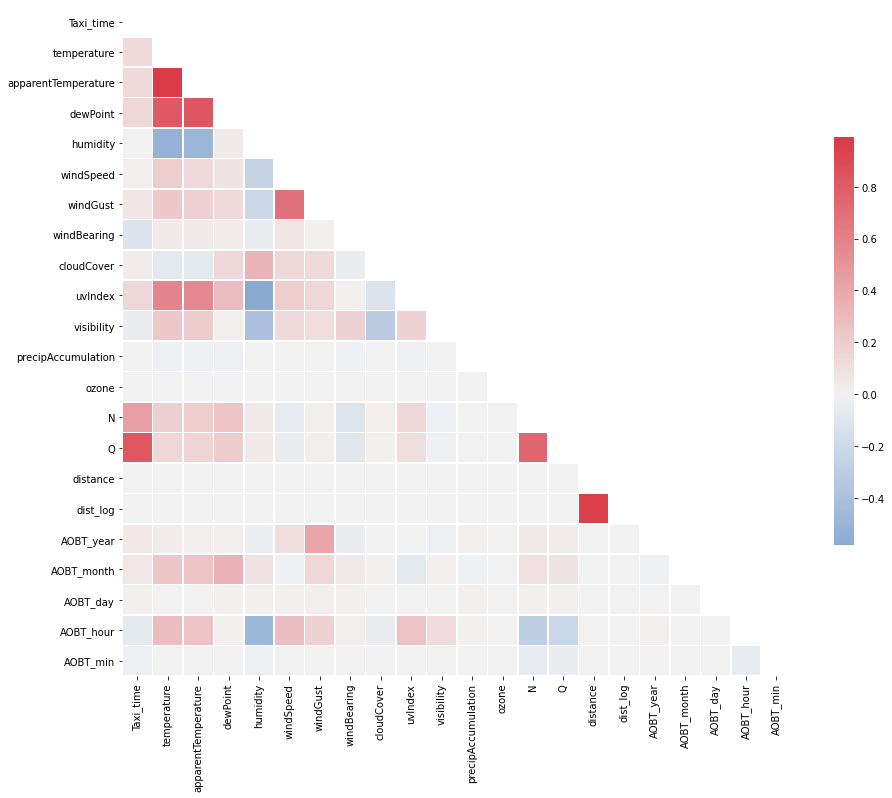

In [36]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.6, cbar_kws={"shrink": .5})

In [37]:
df

,Aircraft Model,AOBT,Stand,Runway,Taxi_time,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone,N,Q,distance,dist_log,AOBT_year,AOBT_month,AOBT_day,AOBT_hour,AOBT_min
0,B737-800 WINGLETS,2015-01-01 05:56:00,STAND_62,RUNWAY_4,540.0,44.65,39.29,42.8,0.93,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4,1,0,745.673967,6.614288,2015,1,1,5,56
1,A320-100/200,2015-01-01 06:08:00,STAND_153,RUNWAY_4,600.0,44.65,39.29,42.8,0.93,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4,2,0,1061.304683,6.967254,2015,1,1,6,8
2,A320-100/200,2015-01-01 06:08:00,STAND_44,RUNWAY_2,660.0,44.65,39.29,42.8,0.93,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4,2,1,3045.847841,8.021535,2015,1,1,6,8
3,A320-100/200,2015-01-01 06:24:00,STAND_7,RUNWAY_3,720.0,44.65,39.29,42.8,0.93,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4,4,3,706.838963,6.560803,2015,1,1,6,24
4,A319,2015-01-01 06:14:00,STAND_17,RUNWAY_2,780.0,44.65,39.29,42.8,0.93,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4,3,2,2589.209331,7.859108,2015,1,1,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543808,A350-900,2018-12-31 21:02:00,STAND_150,RUNWAY_3,1080.0,47.88,44.35,41.0,0.77,7.62,27.73,262.0,1.00,0.0,6.216,None,0.0,310.4,2,1,1430.108629,7.265506,2018,12,31,21,2
543809,B787-900,2018-12-31 21:24:00,STAND_77,RUNWAY_1,840.0,48.26,44.18,41.0,0.76,9.18,27.73,281.0,1.00,0.0,6.216,None,0.0,310.4,1,0,3230.219332,8.080305,2018,12,31,21,24
543810,A330-200,2018-12-31 22:27:00,STAND_120,RUNWAY_1,600.0,48.26,44.18,41.0,0.76,9.18,27.73,281.0,1.00,0.0,6.216,None,0.0,310.4,2,1,2008.758160,7.605272,2018,12,31,22,27
543811,B787-800 Dreamliner,2018-12-31 22:09:00,STAND_49,RUNWAY_2,1200.0,48.26,44.18,41.0,0.76,9.18,27.73,281.0,1.00,0.0,6.216,None,0.0,310.4,1,0,2531.339473,7.836504,2018,12,31,22,9


In [38]:
df.to_csv('train_df_1.csv')

# Test Data

In [62]:
geographic_test_df = pd.read_csv('geographic_data.csv')
airport_test_df = pd.read_csv('test_set_airport_data.csv')
weather_test_df = pd.read_csv('test_set_weather_data.csv')
# Converted the ACchar.xlsx to a csv file
AC_test_df = pd.read_csv('ACchar.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merging Datasets

### Airport Dataset

In [63]:
airport_test_df.head()

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway
0,1/1/2019 6:00,B737-800 WINGLETS,1/1/2019 5:56,1/1/2019 6:03,STAND_163,RUNWAY_2
1,1/1/2019 6:05,A319,1/1/2019 5:58,1/1/2019 6:06,STAND_29,RUNWAY_2
2,1/1/2019 6:10,A320-100/200,1/1/2019 6:06,1/1/2019 6:19,STAND_82,RUNWAY_2
3,1/1/2019 6:10,B787-900,1/1/2019 6:05,1/1/2019 6:21,STAND_159,RUNWAY_2
4,1/1/2019 6:20,A320-100/200,1/1/2019 6:12,1/1/2019 6:24,STAND_94,RUNWAY_2


In [64]:
airport_test_df.describe()

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway
count,135089,135089,135089,135089,135089,135089
unique,61582,99,116138,133930,167,4
top,4/11/2019 9:00,A320-100/200,1/24/2019 12:58,12/29/2019 19:20,STAND_130,RUNWAY_2
freq,8,43373,5,2,870,33989


In [65]:
airport_test_df['Flight Datetime'] = pd.to_datetime(airport_test_df['Flight Datetime'], format = '%m/%d/%Y %H:%M')
airport_test_df['AOBT'] =  pd.to_datetime(airport_test_df['AOBT'], format='%m/%d/%Y %H:%M')
airport_test_df['ATOT'] =  pd.to_datetime(airport_test_df['ATOT'], format='%m/%d/%Y %H:%M')

### Geographic Dataset

In [66]:
geographic_test_df.describe()

,Lat_runway,Lng_runway,Lat_stand,Lng_stand
count,19545.000000,19545.000000,19545.000000,19545.000000
mean,54.757430,-0.007600,54.767112,0.015223
std,0.002815,0.020570,0.002567,0.006758
min,54.755307,-0.024107,54.761081,-0.009674
25%,54.755307,-0.023040,54.765141,0.010050
50%,54.755307,-0.023040,54.766471,0.016204
75%,54.761173,0.019840,54.769007,0.020901
max,54.761493,0.019840,54.773947,0.026379


In [67]:
# Merging airport_df with geographic_df on the runway and stand columns
runway_test_df = np.hsplit(geographic_test_df, 2)[0].drop_duplicates()
stand_test_df = np.hsplit(geographic_test_df, 2)[1].drop_duplicates()

In [68]:
runway_test_df.describe()

,runway,Lat_runway,Lng_runway
count,4,4.000000,4.000000
unique,4,4.000000,4.000000
top,Runway_1,54.761173,-0.024107
freq,1,1.000000,1.000000


In [69]:
stand_test_df.describe()

,stand,Lat_stand,Lng_stand
count,167,167.000000,167.000000
unique,167,159.000000,165.000000
top,stand_100,54.770717,-0.001061
freq,1,2.000000,2.000000


In [70]:
runway_test_df['runway'] = runway_test_df['runway'].str.upper()
stand_test_df['stand'] = stand_test_df['stand'].str.upper()
runway_test_df['runway'] = np.where(runway_test_df['runway'] == 'RUNWAY_3', 'RUNWAY_4', runway_test_df['runway'])
runway_test_df['runway'] = np.where(runway_test_df['runway'] == 'RUNWAY_2', 'RUNWAY_3', runway_test_df['runway'])
runway_test_df['runway'] = np.where(runway_test_df['runway'] == 'RUNWAY_1', 'RUNWAY_2', runway_test_df['runway'])
runway_test_df['runway'] = np.where(runway_test_df['runway'] == 'RUNWAY_0', 'RUNWAY_1', runway_test_df['runway'])

test_df = pd.merge(airport_test_df, stand_test_df, left_on='Stand', right_on='stand', how='left')
test_df = pd.merge(test_df, runway_test_df, left_on='Runway', right_on='runway', how='left')
test_df = test_df.drop(columns = ['runway','stand'])

In [71]:
test_df['Taxi_time'] = (test_df['ATOT'] - test_df['AOBT'])/(np.timedelta64(1,'m')) * 60

### ACchar Dataset

In [184]:
ac_df = AC_df[['A320-100', 'ICAO Code', 'Wake Category']]
ac_df = ac_df.drop_duplicates()

In [185]:
ac_df

,A320-100,ICAO Code,Wake Category
0,Acro Sport,ACRO,L
1,Acro Sport II,ACR2,L
2,Cougar,COUG,L
3,Junior Ace,JACE,L
4,Super Ace,SACE,L
...,...,...,...
2759,Zlin Z-50,BA11,M
2760,Zlin Z-526 Akrobat,tbd,tbd
2761,Zlin Z-526 Trener Master,tbd,tbd
2762,Zlin Z-626,tbd,tbd


In [186]:
#df = pd.merge(df, ac_df, left_on = 'Aircraft Model', right_on = 'A320-100', how = 'left')

In [187]:
df['Aircraft Model'].unique()

array(['B737-800 WINGLETS', 'A320-100/200', 'A319', 'A321-100/200',
       'B737-400', 'A330-300', 'B787-800 Dreamliner', 'B757-200 WINGLETS',
       'A330-200', 'B747-400 Passenger', 'B777-300ER', 'B777-200',
       'B737-900ER', 'ERJ-195', 'DASH 8-Q400', 'A380-800',
       'L-100 HERCULES(C130) Freighter', 'A318', 'ATR 72-500', 'EMB-135',
       'B777-200LR', 'B737-700 WINGLETS', 'EMBRAER E75', 'B737-300',
       '100', 'B737-300 Freighter', 'B 95 TRAVEL AIR',
       'BD700 1A11 GLOBAL EXPRESS', 'B777-200ER', 'LEARJET 60',
       'P.180 AVANTI', 'A340-200', 'RJ100/115', 'EMB-170', 'ERJ-190',
       'EMB-500 PHENOM 100', 'CITATION 1 (C500)', 'Jet', 'A310-300',
       'B757-200 Passenger', 'FALCON 7X', 'G V', 'B737-500',
       'SA 365 DAUPHIN 2', 'PREMIER 1', 'C 550 CITATION II / BRAVO',
       'A109', 'C 180 SKYWAGON', 'C 510 MUSTANG',
       'BD700 1A10 GLOBAL EXPRESS', 'LEARJET 45', 'G IV / IV-SP',
       'EMB-145', 'B737-700', 'CHALLENGER 300', ' ', 'A340-600', '340',
       'CITA

In [188]:
df.isnull().sum()

Aircraft Model         0
Stand                  0
Runway                 0
Taxi_time              0
precipIntensity        0
precipProbability      0
temperature            0
apparentTemperature    0
dewPoint               0
humidity               0
pressure               0
windSpeed              0
windGust               0
windBearing            0
cloudCover             0
uvIndex                0
visibility             0
precipAccumulation     0
ozone                  0
Windy                  0
Cloudy                 0
Rain                   0
Snow                   0
Fog                    0
N                      0
Q                      0
distance               0
dist_log               0
AOBT_year              0
AOBT_month             0
AOBT_day               0
AOBT_hour              0
AOBT_min               0
dtype: int64

### Weather Dataset

In [74]:
weather_test_df.describe()

,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipAccumulation,ozone
count,132234.000000,135090.000000,135090.000000,135090.000000,135090.000000,132234.000000,135072.00000,132480.000000,135060.000000,134964.000000,134982.000000,135072.000000,135090.000000,135090.000000
mean,0.104545,53.871694,52.198201,47.030591,0.797294,1014.518521,9.47534,17.109090,195.411276,0.578384,1.236283,7.502852,0.000015,328.951492
std,0.185249,10.770997,12.666926,8.631649,0.161783,11.328873,5.08670,9.537596,91.278894,0.317666,1.661616,1.747038,0.000753,43.671716
min,0.000000,20.350000,14.650000,20.230000,0.270000,972.300000,0.00000,1.090000,0.000000,0.000000,0.000000,0.074000,0.000000,212.500000
25%,0.000000,46.320000,41.890000,40.930000,0.680000,1007.300000,5.74000,9.140000,130.000000,0.310000,0.000000,7.119000,0.000000,300.300000
50%,0.010000,53.240000,53.240000,46.930000,0.830000,1015.100000,8.48000,15.950000,216.000000,0.650000,0.000000,7.438000,0.000000,327.800000
75%,0.110000,61.130000,61.290000,53.730000,0.930000,1022.400000,12.47000,23.670000,252.000000,0.790000,2.000000,7.516000,0.000000,354.900000
max,0.880000,93.510000,96.700000,69.450000,1.000000,1040.800000,33.12000,51.310000,359.000000,1.000000,8.000000,10.000000,0.137400,480.000000


In [73]:
weather_test_df.duplicated().sum()

128317

In [75]:
weather_test_df = weather_test_df.drop_duplicates(keep = 'first')
weather_test_df = weather_test_df.drop(columns = ['summary', 'icon', 'precipIntensity', 'precipProbability', 'pressure'])
weather_test_df = weather_test_df.fillna(method = 'ffill')
weather_test_df = weather_test_df.fillna({"windGust": weather_test_df['windGust'].mean()})

In [81]:
weather_test_df.isnull().sum()

time_hourly            0
temperature            0
apparentTemperature    0
dewPoint               0
humidity               0
windSpeed              0
windGust               0
windBearing            0
cloudCover             0
uvIndex                0
visibility             0
precipType             0
precipAccumulation     0
ozone                  0
dtype: int64

In [84]:
weather_test_df

,time_hourly,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone
0,1/1/2019 0:00,47.73,44.04,41.00,0.77,7.91,17.220851,287.0,1.00,0.0,6.216,None,0.0,310.4
1,1/1/2019 6:00,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4
8,1/1/2019 7:00,46.46,43.56,39.22,0.76,5.82,17.220851,262.0,0.75,0.0,6.216,None,0.0,310.4
11,1/1/2019 7:00,46.46,43.56,39.22,0.76,5.82,17.220851,262.0,0.75,0.0,6.216,None,0.0,310.4
35,1/1/2019 8:00,44.30,40.28,40.20,0.85,7.08,17.220851,270.0,0.44,0.0,6.216,None,0.0,310.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135056,12/31/2019 19:00,44.49,38.74,41.55,0.89,11.24,18.590000,91.0,0.75,0.0,6.933,None,0.0,316.3
135066,12/31/2019 20:00,44.39,39.13,42.47,0.93,9.89,19.320000,92.0,0.51,0.0,7.456,None,0.0,315.5
135081,12/31/2019 21:00,44.17,39.56,39.23,0.83,8.25,20.270000,102.0,0.26,0.0,6.391,None,0.0,313.3
135086,12/31/2019 22:00,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6


In [85]:
#Create new column rounding flight datetime to nearest hour for mapping
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

test_df["Flight_Datetime_map"] = test_df["Flight Datetime"].map(lambda d: hour_rounder(d))

weather_test_df['time_hourly'] = pd.to_datetime(weather_test_df['time_hourly'])
#Left join train data with weather data on "Flight_Datetime_map" & "time_hourly"
test_df = pd.merge(test_df, weather_test_df, left_on="Flight_Datetime_map", right_on= "time_hourly", how='left')
test_df = test_df.drop(columns = 'time_hourly')

In [86]:
test_df

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway,Lat_stand,Lng_stand,Lat_runway,Lng_runway,Taxi_time,Flight_Datetime_map,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone
0,2019-01-01 06:00:00,B737-800 WINGLETS,2019-01-01 05:56:00,2019-01-01 06:03:00,STAND_163,RUNWAY_2,54.7652,0.00384885,54.7571,-0.0241067,420.0,2019-01-01 06:00:00,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4
1,2019-01-01 06:05:00,A319,2019-01-01 05:58:00,2019-01-01 06:06:00,STAND_29,RUNWAY_2,54.7731,0.00648597,54.7571,-0.0241067,480.0,2019-01-01 06:00:00,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4
2,2019-01-01 06:10:00,A320-100/200,2019-01-01 06:06:00,2019-01-01 06:19:00,STAND_82,RUNWAY_2,54.7623,-0.00032,54.7571,-0.0241067,780.0,2019-01-01 06:00:00,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4
3,2019-01-01 06:10:00,B787-900,2019-01-01 06:05:00,2019-01-01 06:21:00,STAND_159,RUNWAY_2,54.7698,0.00756736,54.7571,-0.0241067,960.0,2019-01-01 06:00:00,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4
4,2019-01-01 06:20:00,A320-100/200,2019-01-01 06:12:00,2019-01-01 06:24:00,STAND_94,RUNWAY_2,54.769,0.010717,54.7571,-0.0241067,720.0,2019-01-01 06:00:00,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135134,2019-12-31 21:25:00,A320-100/200,2019-12-31 21:04:00,2019-12-31 21:17:00,STAND_154,RUNWAY_3,54.7631,-0.00880299,54.7612,0.01984,780.0,2019-12-31 21:00:00,44.17,39.56,39.23,0.83,8.25,20.270000,102.0,0.26,0.0,6.391,None,0.0,313.3
135135,2019-12-31 21:30:00,B787-900,2019-12-31 21:16:00,2019-12-31 21:34:00,STAND_142,RUNWAY_2,54.7634,0.0113452,54.7571,-0.0241067,1080.0,2019-12-31 22:00:00,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6
135136,2019-12-31 21:40:00,A320 NEO,2019-12-31 21:38:00,2019-12-31 21:56:00,STAND_145,RUNWAY_1,54.7647,0.00846219,54.7553,-0.02304,1080.0,2019-12-31 22:00:00,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6
135137,2019-12-31 21:55:00,A321-100/200,2019-12-31 21:47:00,2019-12-31 22:01:00,STAND_164,RUNWAY_3,54.7697,0.00762667,54.7612,0.01984,840.0,2019-12-31 22:00:00,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6


## Preprocessing

In [87]:
test_df.isnull().sum()

Flight Datetime          0
Aircraft Model           0
AOBT                     0
ATOT                     0
Stand                    0
Runway                   0
Lat_stand              734
Lng_stand              734
Lat_runway               0
Lng_runway               0
Taxi_time                0
Flight_Datetime_map      0
temperature             25
apparentTemperature     25
dewPoint                25
humidity                25
windSpeed               25
windGust                25
windBearing             25
cloudCover              25
uvIndex                 25
visibility              25
precipType              25
precipAccumulation      25
ozone                   25
dtype: int64

In [88]:
test_df = test_df.fillna(method = 'ffill')

In [89]:
# filled all NA values
test_df.isnull().sum()

Flight Datetime        0
Aircraft Model         0
AOBT                   0
ATOT                   0
Stand                  0
Runway                 0
Lat_stand              0
Lng_stand              0
Lat_runway             0
Lng_runway             0
Taxi_time              0
Flight_Datetime_map    0
temperature            0
apparentTemperature    0
dewPoint               0
humidity               0
windSpeed              0
windGust               0
windBearing            0
cloudCover             0
uvIndex                0
visibility             0
precipType             0
precipAccumulation     0
ozone                  0
dtype: int64

In [90]:
df.duplicated().sum()

0

## Feature Engineering

### Calculating Q and N

In [91]:
def overlap_taxi(date,date_1,date_2):
  if date >= date_1 and date <= date_2:
    return 1
  else:
    return 0

In [93]:
Q = []
N = []

AOBT_list = list(test_df['AOBT'])
ATOT_list = list(test_df['ATOT'])

# number of stands in use =  number of airplanes taxiing
airplanes_taxi = len(test_df['Stand'].unique())

for index in range(len(test_df)):
    # AOBT and ATOT of a given index
    AOBT = AOBT_list[index]
    ATOT = ATOT_list[index]
    
    # min number of iterations for a given index
    index_min = max(0, index - airplanes_taxi)
    # max number of iterations for a given index
    index_max = min(index + airplanes_taxi, len(df))
    
    AOBT_range = AOBT_list[index_min : index_max]
    ATOT_range = ATOT_list[index_min : index_max]

    # check if other airplanes are taxiing when the given airplane taxis
    N_overlap = map(lambda x, y: overlap_taxi(AOBT, x, y), AOBT_range, ATOT_range)
    # count the total number of airplanes that are taxiing when the given airplane leaves its stand (including the given airplane)
    N_count = max(0,sum(list(N_overlap))-1) + 1
    N.append(N_count)

    # check if other airplanes stop taxiing when the given airplane taxis
    Q_overlap = map(lambda x: overlap_taxi(x, AOBT, ATOT), ATOT_range)
    # count the total number of airplanes that stop taxiing
    Q_count = max(0, sum(list(Q_overlap))-1)
    Q.append(Q_count)


In [94]:
test_df['N'] = N
test_df['Q'] = Q

### Calculating distance and log(distance)

In [95]:
# Calculating the distance between the stand and runway
def coordinate_dist(lat_1, lng_1, lat_2, lng_2):
  diff_lat = (lat_1 - lat_2) * np.pi / 180
  diff_lng = (lng_1 - lng_2) * np.pi / 180

  lat_1 = lat_1 * np.pi / 180
  lat_2 = lat_2 * np.pi / 180

  a = np.sin(diff_lat/2) * np.sin(diff_lat/2) + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lng/2) * np.sin(diff_lng/2)
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  distance = 6371 * c * 1000

  return distance

In [96]:
test_df['distance'] = test_df.apply(lambda x: coordinate_dist(x.Lat_stand, x.Lng_stand, x.Lat_runway, x.Lng_runway), axis=1)
test_df['dist_log'] = np.log(test_df['distance'].apply(lambda x: float(x)))

In [97]:
test_df = test_df.drop(columns = ['Lat_stand', 'Lng_stand', 'Lat_runway', 'Lng_runway'])

### Calculating datetime of AOBT

In [98]:
test_df['AOBT_year'] = test_df['AOBT'].dt.year
test_df['AOBT_month'] = test_df['AOBT'].dt.month
test_df['AOBT_day'] = test_df['AOBT'].dt.day
test_df['AOBT_hour'] = test_df['AOBT'].dt.hour
test_df['AOBT_min'] = test_df['AOBT'].dt.minute

In [99]:
test_df = test_df.drop(columns = ['Flight Datetime', 'Flight_Datetime_map', 'ATOT'])

In [100]:
test_df

,Aircraft Model,AOBT,Stand,Runway,Taxi_time,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone,N,Q,distance,dist_log,AOBT_year,AOBT_month,AOBT_day,AOBT_hour,AOBT_min
0,B737-800 WINGLETS,2019-01-01 05:56:00,STAND_163,RUNWAY_2,420.0,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4,1,0,2004.252900,7.603027,2019,1,1,5,56
1,A319,2019-01-01 05:58:00,STAND_29,RUNWAY_2,480.0,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4,2,1,2646.514731,7.880999,2019,1,1,5,58
2,A320-100/200,2019-01-01 06:06:00,STAND_82,RUNWAY_2,780.0,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4,3,1,1629.695742,7.396149,2019,1,1,6,6
3,B787-900,2019-01-01 06:05:00,STAND_159,RUNWAY_2,960.0,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4,2,2,2475.432954,7.814171,2019,1,1,6,5
4,A320-100/200,2019-01-01 06:12:00,STAND_94,RUNWAY_2,720.0,46.46,42.44,41.00,0.81,8.05,17.220851,285.0,0.75,0.0,6.216,None,0.0,310.4,3,2,2595.850587,7.861670,2019,1,1,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135134,A320-100/200,2019-12-31 21:04:00,STAND_154,RUNWAY_3,780.0,44.17,39.56,39.23,0.83,8.25,20.270000,102.0,0.26,0.0,6.391,None,0.0,313.3,2,1,1850.722625,7.523331,2019,12,31,21,4
135135,B787-900,2019-12-31 21:16:00,STAND_142,RUNWAY_2,1080.0,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6,3,2,2377.947990,7.773993,2019,12,31,21,16
135136,A320 NEO,2019-12-31 21:38:00,STAND_145,RUNWAY_1,1080.0,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6,2,1,2272.955421,7.728836,2019,12,31,21,38
135137,A321-100/200,2019-12-31 21:47:00,STAND_164,RUNWAY_3,840.0,42.40,37.00,40.55,0.93,9.11,19.940000,93.0,0.08,0.0,10.000,None,0.0,311.6,3,2,1226.979593,7.112311,2019,12,31,21,47


In [102]:
test_df.to_csv('test_df_1.csv')

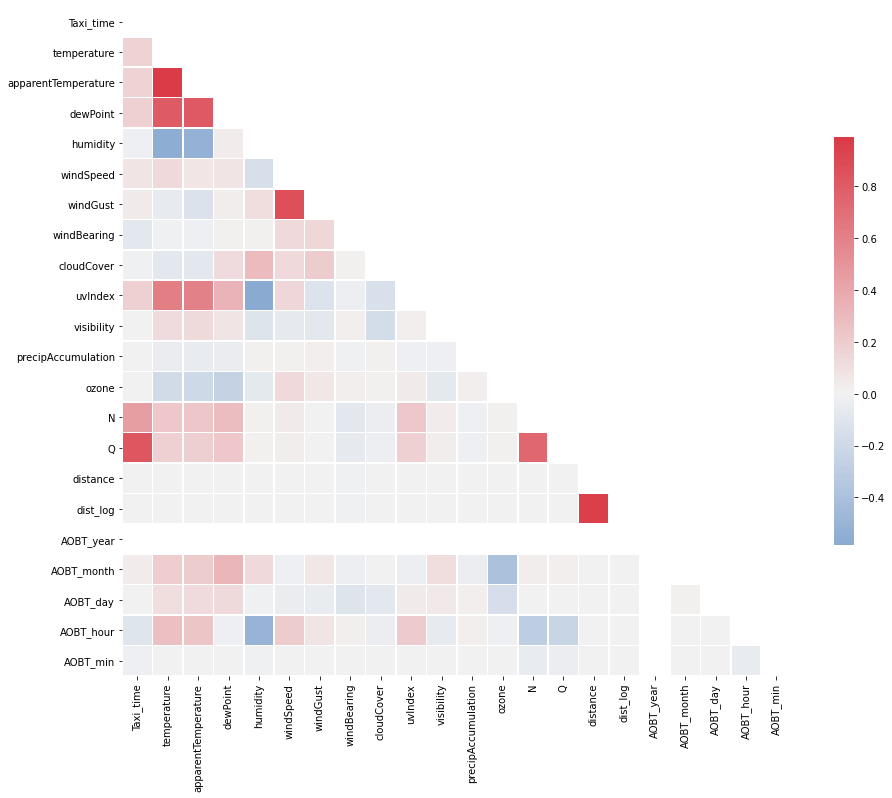

In [103]:
corr = test_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.6, cbar_kws={"shrink": .5})

# Full Weather Set

In [ ]:
train_weather_df = pd.read_csv('training_set_weather_data.csv')

In [ ]:
train_weather_df.head()

,Flight Number,Flight Datetime,Aircraft Model,Aircraft Length,Aircraft Span,No. Engines,Airport Arrival/Departure,Movement Type,AOBT,ATOT,Distance_proxy_m,Log_distance_m,actual_taxi_out_sec,Year,Month,Weekday,Hour,N_dep_dep,N_dep_arr,Q_dep_dep,Q_dep_arr,time_hourly,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone
0,DY2434,1/1/2015 6:00,B737-800 WINGLETS,39.50,35.70,2,TFS,D,1/1/2015 5:56,1/1/2015 6:05,3276.655443,8.094578,540.0,2015.0,1.0,3.0,6.0,3.0,2.0,0.0,1.0,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
1,EZY8869,1/1/2015 6:10,A320-100/200,56.70,60.00,2,AMS,D,1/1/2015 6:08,1/1/2015 6:18,2777.685343,7.929373,600.0,2015.0,1.0,3.0,6.0,6.0,1.0,1.0,1.0,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
2,EZY8462,1/1/2015 6:15,A320-100/200,37.56,34.09,2,GVA,D,1/1/2015 6:08,1/1/2015 6:19,2729.133359,7.911739,660.0,2015.0,1.0,3.0,6.0,6.0,1.0,2.0,2.0,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
3,BA2632,1/1/2015 6:20,A320-100/200,37.56,34.09,2,ALC,D,1/1/2015 6:24,1/1/2015 6:36,2292.070065,7.737211,720.0,2015.0,1.0,3.0,6.0,9.0,2.0,5.0,1.0,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
4,EZY5381,1/1/2015 6:20,A319,33.84,34.09,2,MUC,D,1/1/2015 6:14,1/1/2015 6:27,3194.416489,8.069160,780.0,2015.0,1.0,3.0,6.0,6.0,1.0,2.0,2.0,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4


In [ ]:
corr = train_weather_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.6, cbar_kws={"shrink": .5})